## Processing newly collected data
A new set of data containing images of swedish traffic signs was collected. The image content was labeled by hand with bounding boxes using roboflow. The resulting dataset was exported with labels in the Yolov8 OBB format. This notebook aims to process the data and create a set of traffic sign images simmilar to the GTSRB dataset. 

In [1]:
test_image = "swedishdata/train/images/IMG_0785_JPEG.rf.967117d7529296de55bf4a40e7814aef.jpg"
test_image_labels = "swedishdata/train/labels/IMG_0785_JPEG.rf.967117d7529296de55bf4a40e7814aef.txt"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

### Testing the bounding boxes from the yolov8 bbd file
Loading the image and coordinates of the bounding box. The coordinates are used to create a rectangle based on two diagonally opposit points. 

(2048, 1536, 3)


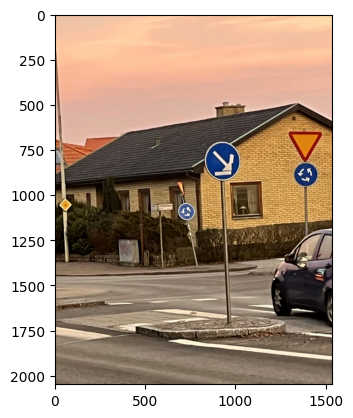

In [3]:
img = cv2.imread(test_image)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

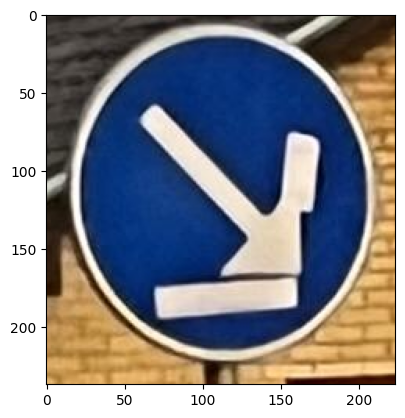

In [4]:
x1,y1,x2,y2,x3,y3,x4,y4 = 0.6751302083333334, 0.34179687500000006, 0.529296875, 0.341796875, 0.5292968750000001, 0.45751953125000006, 0.6751302083333334, 0.4575195312500001
top_left_x = int(min([x1,x2,x3,x4])*img.shape[1])
top_left_y = int(min([y1,y2,y3,y4])*img.shape[0])
bot_right_x = int(max([x1,x2,x3,x4])*img.shape[1])
bot_right_y = int(max([y1,y2,y3,y4])*img.shape[0])
rectangle_selection = img[top_left_y:bot_right_y, top_left_x:bot_right_x]
plt.imshow(rectangle_selection)


### Processing the images
Parse the corresponding label txt with the bounding box coordinates and the bounded image label. Using this to crop out the bounded box and save its contents. 

In [5]:
class_dict = {0: 1,
  1: 12,
  2: 13,
  3: 14,
  4: 15,
  5: 17,
  6: 2,
  7: 22,
  8: 25,
  9: 27,
  10: 28,
  11: 29,
  12: 33,
  13: 35,
  14: 38,
  15: 39,
  16: 4,
  17: 40}

def parse_line_bounding_box(line:str):
    array:list = line.split(" ")
    label:int = int(array[0])
    x_list:list = [float(array[i].rstrip()) for i in [1,3,5,7]]
    y_list:list = [float(array[i].rstrip()) for i in [2,4,6,8]]
    return class_dict[label], x_list, y_list

def process_cropped_image(img,label, x_list, y_list, show = False, save = False, save_path = ""):
    top_left_x = int(min(x_list)*img.shape[1])
    top_left_y = int(min(y_list)*img.shape[0])
    bot_right_x = int(max(x_list)*img.shape[1])
    bot_right_y = int(max(y_list)*img.shape[0])
    rectangle_selection = img[top_left_y:bot_right_y, top_left_x:bot_right_x]
    if show:
        plt.imshow(rectangle_selection)
        plt.show()
    if save and save_path != "":
        cv2.imwrite(save_path+".png", rectangle_selection)
    
def create_save_path(path, label):
    save_path = f"{path}/{label}"
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    items = os.listdir(save_path)
    return f"{save_path}/{len(items):08d}"


def extract_bounded(image_path, label_file_path, change_color = False, show = False, save = False, save_path = ""):
    img = cv2.imread(image_path)
    if change_color:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    with open(label_file_path, mode="r") as file:
        for line in file:
            label, x_list, y_list = parse_line_bounding_box(line)
            image_save_path = create_save_path(save_path, label)
            process_cropped_image(img, label, x_list, y_list, show=show, save = save, save_path=image_save_path)


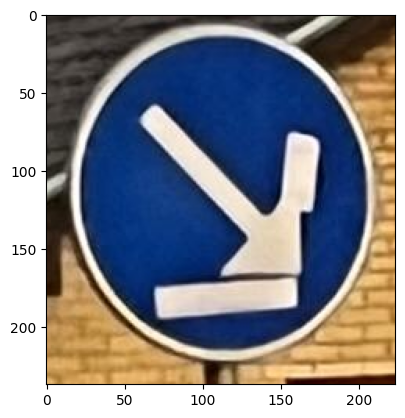

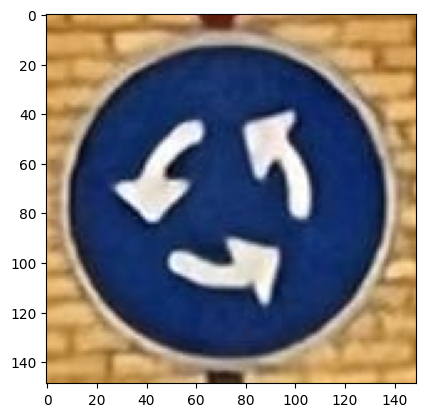

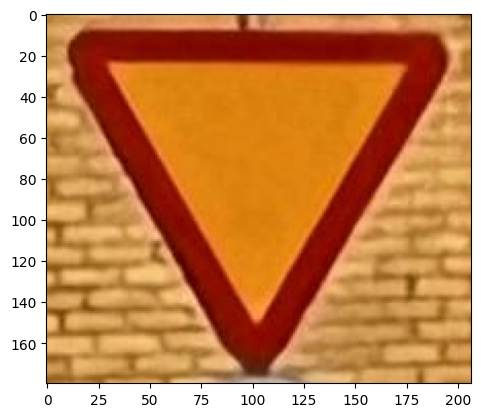

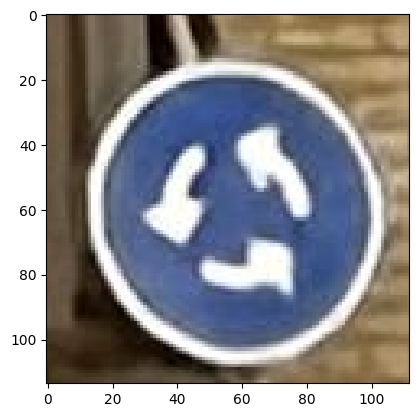

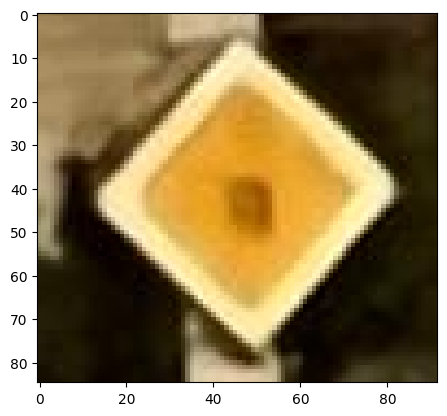

In [6]:
extract_bounded(test_image, test_image_labels, show = True,change_color=True, save= True, save_path="processed_swedish_data") 

### Process all of the images in the directory
All off the images and corresponding label files are combined into a dataframe that is save as a csv. Then bounded boxes are extracted and saved based on their labels.

In [7]:
label_files = os.listdir("swedishdata/train/labels")
file_names = [x[:-4] for x in label_files]
df = pd.DataFrame()
df["image"] = file_names
df["image_path"] = [f"swedishdata/train/images/{file_name}.jpg" for file_name in file_names]
df["bounding_box_path"] = [f"swedishdata/train/labels/{file_name}.txt" for file_name in file_names]


In [8]:
df.to_csv("pre_processing.csv")

In [9]:

for i in range(len(df)):
    item = df.iloc[i]
    extract_bounded(item["image_path"], item["bounding_box_path"],save= True, save_path="processed_swedish_data")

In [17]:
images_path = "processed_swedish_data"
folder_list = os.listdir(images_path)
processed_data_path_train = "rescaled_swedish_processed_data"
if not os.path.exists(f"{processed_data_path_train}"):
        os.mkdir(processed_data_path_train)
for folder in folder_list:
    images = os.listdir(f"{images_path}/{folder}")
    images = list(filter(lambda item:not item.endswith(".csv"),images))
    if not os.path.exists(f"{processed_data_path_train}/{folder}"):
        os.mkdir(f"{processed_data_path_train}/{folder}")
    for image in images:
        img_path = f"{images_path}/{folder}/{image}"
        save_path = f"{processed_data_path_train}/{folder}/{image}"
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64,64))
        cv2.imwrite(save_path[0:-4]+".png", img)

In [21]:
df = pd.DataFrame()
img_path_list = []
folder_list = os.listdir(f"{processed_data_path_train}")
for folder in folder_list:
    images = f"{processed_data_path_train}/{folder}/" + np.array(os.listdir(f"{processed_data_path_train}/{folder}"))
    img_path_list.append(images)
img_path_list = np.concatenate(img_path_list)
df["Path"] = img_path_list
df.to_csv("swedish_labels.csv")
labels = np.array([int(label.split('/')[1]) for label in img_path_list])
df["Labels"] = labels
df.to_csv("swedish_labels.csv")